# <center>DeepIRTools Tutorial:<br><br>Generating Fake Handwriting</center>

The DeepIRTools package includes latent factor models that are capable of representing complex real-world distributions. To demonstrate this capability, this tutorial shows how to fit an identifiable latent factor model using the Modified National Institute of Standards and Technology (MNIST; [LeCun, Cortes, and Burges, 1999](#refs)) database of handwritten digits. Our approach will make use of important tools from both <a href="https://en.wikipedia.org/wiki/Deep_learning">deep learning</a> and <a href="https://en.wikipedia.org/wiki/Psychometrics">psychometrics</a>.

## Pre-Processing

Each observation in the MNIST data set is an image $(z_{i,j}) \in \{0, \ldots, 255\}^{28 \times 28}$ of a handwritten digit accompanied by a label $\ell \in \{0, \ldots, 9\}$ indicating which digit the image contains. In words, each image is a $28 \times 28$ grid of pixels taking integer values between 0 and 255. MNIST comes divided into a training set with 60K observations and a test set with 10K observations. We will build our model using the training set.

To preprocess the data, we follow [Salakhutdinov and Murrary (2008)](#refs) in stochastically binarizing each image as follows:
\begin{equation}
    y_{i,j} \sim \text{Bern}(z_{i,j} / 255),
\end{equation}
where $y_{i,j} \in \{0, 1\}$ is a binary pixel, $i=1, \ldots, 28$, $j=1, \ldots, 28$. Each label is represented as a set of $10 - 1 = 9$ dummy variables where $\ell = 0$ is the reference category. A grid with some binarized images is shown below.

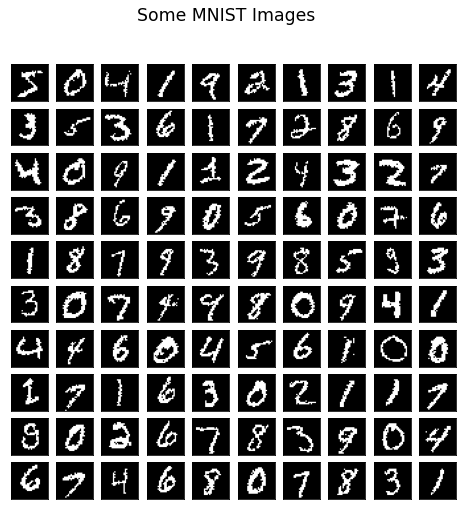

In [1]:
import torch
import torchvision
import deepirtools
from deepirtools import IWAVE
from matplotlib import pyplot as plt
import os

deepirtools.manual_seed(123) # Seed for reproducibility.

def get_dummies(targets): # Converts a K-category covariate into K-1 dummy variables.
    sample_size = targets.shape[0]
    rng = targets.unique().shape[0]
    dummies = torch.zeros(sample_size, rng)
    dummies[torch.arange(sample_size), targets] = 1
    return dummies[:, 1:]

mnist = torchvision.datasets.MNIST("./", download = True)
data = torch.bernoulli(mnist.data.div(255)) # Stochastically binarize images.
labels = get_dummies(mnist.targets)

fig, axes = plt.subplots(10, 10, figsize = (8, 8))
fig.suptitle("Some MNIST Images", fontsize = "xx-large")
for i, ax in enumerate(axes.flat):
    ax.imshow(data[i], cmap = "gray")
    ax.set_xticks([])
    ax.set_yticks([])

## Latent Factor Models

As mentioned above, we will fit a latent factor model using MNIST. Latent factor models posit that the observed data is generated as follows:
\begin{align} \tag{1}
    \begin{split}
            \mathbf{x} &\sim p(\mathbf{x}) \\
            \mathbf{y} \mid \mathbf{x} &\sim p(\mathbf{y} \mid \mathbf{x}),
    \end{split}
\end{align}
where $\mathbf{x}$ is a $D \times 1$ vector of latent factors and $\mathbf{y}$ is a $J \times 1$ vector of observed variables. The distribution $p(\mathbf{x})$ is called the latent variable prior (deep learning) or the population distribution (psychometrics), while the conditional distribution $p(\mathbf{y} \mid \mathbf{x})$ is called the observation model (deep learning) or the measurement model (psychometrics).

In both deep learning and psychometrics, a common choice for the prior distribution of the latent factors is the standard normal:
\begin{equation}
    p(\mathbf{x}) = \mathcal{N}(\boldsymbol{0}, \boldsymbol{I}_D).
\end{equation}
In psychometrics, the measurement model typically takes the form of a generalized linear model:
\begin{equation*}
    \mathbb{E}[\mathbf{y} \mid \mathbf{x}] = g^{-1}(\mathbf{B}\mathbf{x} + \boldsymbol{\alpha}), \tag{2}
\end{equation*}
where $g: \mathbb{R} \rightarrow \mathbb{R}$ is a link function applied elementwise, $\mathbf{B}$ is a $J \times D$ factor loadings matrix, and $\boldsymbol{\alpha}$ is a $J \times 1$ vector of intercepts. In deep learning, the measurement model is typically more flexible:
\begin{equation*}
    \mathbb{E}[\mathbf{y} \mid \mathbf{x}] = g^{-1}(f_\boldsymbol{\theta}(\mathbf{x})), \tag{3}
\end{equation*}
where $f_\boldsymbol{\theta} : \mathbb{R}^D \rightarrow \mathbb{R}^J$ is an arbitrary continuous map implemented as a neural network parameterized by $\boldsymbol{\theta}$.  (3) is called the nonlinear factor model ([Yalcin and Amemiya, 2001](#refs)) and is typically implemented as a variational autoencoder (VAE; [Kingma and Welling, 2014](#refs); [Rezende, Mohamed, and Wierstra, 2014](#refs)). Clearly $(2)$ is a special case of $(1)$ with $\boldsymbol{\theta} = (\text{vec}(\mathbf{B})^\top, \boldsymbol{\alpha}^\top)^\top$.

## The Problem of Model Non-Identifiability

Since image data are complex, it may initially seem like a flexible neural network-based measurement model is the best choice for MNIST. Unfortunately, the neural network-based model suffers from a major drawback: It is not identifiable ([Khemakhem, Kingma, Pio Monte, and Hyvärinen, 2020](#refs)). Let $\boldsymbol{\omega} \in \Omega$ collect the parameters of $(1)$.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) Formally, model non-identifiability means that
\begin{equation}
    \forall \hat{\boldsymbol{\omega}}, \hat{\boldsymbol{\omega}}' : p_{\hat{\boldsymbol{\omega}}}(\mathbf{y}) = p_{\hat{\boldsymbol{\omega}}'}(\mathbf{y}) \;\not\!\!\!\!\implies \hat{\boldsymbol{\omega}} = \hat{\boldsymbol{\omega}}'.
\end{equation}
In words, the model is not identifiable if we can find two or more distinct values of $\boldsymbol{\omega}$ that produce the same marginal likelihood. Non-identifiability of the nonlinear factor model (3) implies that we may never recover the true joint distribution of $\mathbf{y}$ and $\mathbf{x}$ (up to an equivalence class), even in the limit of infinite data.

Fortunately, we may leverage tools from both psychometrics and deep learning to fit a latent factor model that is both highly flexible and identifiable. Specifically, we will combine a generalized linear measurement model and identification constraints with a flexible normalizing flow-based latent variable prior. We discuss these components below.

The measurement model is an item response theory (IRT) model called the multidimensional two-parameter logistic model (M2PL; [McKinley and Reckase, 1983](#refs)):
\begin{equation}
    \text{Pr}(\mathbf{y} = \mathbf{1} \mid \mathbf{x}) = \sigma(\mathbf{B} \mathbf{x} + \boldsymbol{\alpha}),
\end{equation}
where $\sigma(u) = 1 / (1 + \exp[-u])$ is the sigmoid function (deep learning) or inverse logistic link function (psychometrics) applied elementwise. The latent variable prior is a normalizing flow-based density ([Tabak & Turner, 2012](#refs); [Tabak & Vanden-Eijnden, 2010](#refs)):
\begin{equation}
    \mathbf{x} = 
\end{equation}


Since $\mathbf{x}$ is latent, we need to establish a metric of measurement by identifying its location and scale. This is straightforward for generalized linear latent factor models like the M2PL: We may identify the location by fixing $D$ elements of $\boldsymbol{\alpha}$ to zero and we may identify the scale by fixing one element in each column of $\mathbf{B}$ to one.<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

<a name="cite_note-1"></a>1. [^](#cite_ref-1) $\boldsymbol{\omega}$ includes the parameters of the neural network in function space rather than the learned parameters $\boldsymbol{\theta}$ ([Section 2.2, Khemakhem, Kingma, Pio Monte, and Hyvärinen, 2020](#refs)).

<a name="cite_note-2"></a>2. [^](#cite_ref-2) For a concise review of identification constraints and a discussion of associated challenges, see [Millsap, 2001](#refs).

## Conditional Generative Models

Sampling from a fitted latent factor model ideally produces a random sample of realistic fake observations. In many image modeling applications, however, the goal is to generate realistic fake images while exerting some degree of control over the *kinds* of images generated. With MNIST, for example, we may wish to choose which digits to generate from our fitted model. This can be accomplished by conditioning the model on covariates as follows:
\begin{align}
    \mathbf{x} \mid \mathbf{c} &\sim p(\mathbf{x} \mid \mathbf{c}) \\
    \mathbf{y} \mid \mathbf{x}, \mathbf{c} &\sim p(\mathbf{y} \mid \mathbf{x}, \mathbf{c}),
\end{align}
where $\mathbf{c}$ is a $C \times 1$ vector of covariates. Conditional latent factor models are typically implemented as conditional VAEs ([Sohn, Yan, and Lee, 2015](#refs)) in deep learning and as latent regression models ([Camilli and Fox, 2015](#refs); [von Davier and Sinharay, 2010](#refs)) in psychometrics.

In [2]:
sample_size = data.shape[0]
Y = data.view(sample_size, -1)
n_items = Y.shape[1]
latent_size = 32
ref_idxs = Y.var(dim = 0).sort(descending = True)[1][:latent_size]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A = torch.ones(latent_size * n_items)
b = torch.zeros(latent_size * n_items)
for factor_idx in range(latent_size):
    ref_idx = ref_idxs[factor_idx]
    A[n_items * factor_idx + ref_idx] = 0
    b[n_items * factor_idx + ref_idx] = 1
A = A.diag()
ints_mask = torch.ones(n_items); ints_mask[ref_idxs] = 0

load_model = os.path.exists("./models/conditional_mnist.pth")

model = IWAVE(model_type = "grm",
              learning_rate = 1e-3,
              device = device,
              A = A,
              b = b,
              ints_mask = ints_mask,
              inference_net_sizes = [256],
              latent_size = latent_size,
              n_cats = [2] * n_items,
              fixed_variances = False,
              fixed_means = False,
              covariate_size = labels.shape[1],
              use_spline_prior = True,
              count_bins = 32,
              spline_net_sizes = [128],
              spline_init_normal = not load_model,
              log_interval = 25,
             )
if load_model:
    model.load_model("conditional_mnist", "./models")
else:
    model.fit(Y, batch_size = 1024, covariates = labels)
    os.makedirs("./models", exist_ok = True)
    model.save_model("conditional_mnist", "./models")


Initializing model parameters
Initialization ended in  0.03  seconds


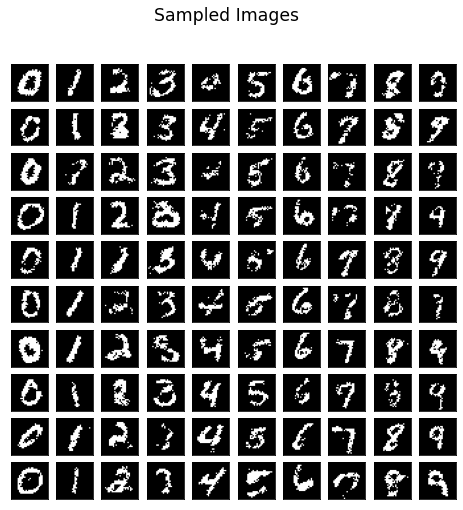

In [3]:
sampled_labels = get_dummies(torch.cat([torch.arange(10)] * 10, dim = 0))
obs = model.sample(sample_size = 100, covariates = sampled_labels)["obs"]

fig, axes = plt.subplots(10, 10, figsize = (8, 8))
fig.suptitle("Sampled Images", fontsize = "xx-large")
for i, ax in enumerate(axes.flat):
    ax.imshow(obs[i].reshape(-1, 28, 28)[0], cmap = "gray")
    ax.set_xticks([])
    ax.set_yticks([])

## References <a id='refs'></a>

- Camilli, G., & Fox, J.-P. (2015). An aggregate IRT procedure for exploratory factor analysis. *Journal of Educational and Behavioral Statistics*, *40*, 377–401.

- Khemakhem, I., Kingma, D. P., Pio Monte, R., and Hyvärinen, A. (2020). Variational autoencoders and nonlinear ICA:
A unifying framework. In *Proceedings of the 23<sup>rd</sup> International Conference on Artificial
Intelligence and Statistics*, *108*.

- Kingma, D. P., & Welling, M. (2014). Auto-encoding variational Bayes. In *2<sup>nd</sup> International Conference on Learning
Representations*. ICLR.

- LeCun, Y., Cortes, C., & Burges, C. J. C. (1999). The MNIST database of handwritten digits. Retrieved from http://yann.lecun.com/exdb/mnist/

- McKinley, R., & Reckase, M. (1983). An extension of the two-parameter logistic model to the multidimensional latent
space (Research Report ONR83-2). The American College Testing Program.

- Millsap, R. E. (2001) When trivial constraints are not trivial: The choice of uniqueness constraints in confirmatory factor analysis. *Structural Equation Modeling*, *8*(1), 1–17

- Rezende, D. J., Mohamed, S., & Wierstra, D. (2014). Stochastic backpropagation and approximate inference in deep
generative models. In *Proceedings of the 31<sup>st</sup> International Conference on Machine Learning* (pp. 1278–1286).

- Salakhutdinov, R., & Murray, I. (2008). On the quantitative analysis of deep belief networks. In *Proceedings of the 25<sup>th</sup> International Conference on Machine Learning*.

- Sohn, K., Yan, X., & Lee, H. (2015). Learning structured output representation using deep conditional generative models. *Advances in Neural Information Processing Systems*, *28*.

- Tabak, E. G., & Turner, C. V. (2012). A family of nonparametric density estimation algorithms. *Communications on Pure and Applied Mathematics*, *66*(2), 145–164.

- Tabak, E. G., & Vanden-Eijnden, E. (2010). Density estimation by dual ascent of the log-likelihood. *Communications in Mathematical Sciences*, *8*(1), 217–233.

- von Davier, M., & Sinharay, S. (2010). Stochastic approximation methods for latent regression item response models. *Journal of Educational and Behavioral Statistics*, *35*(2), 174–193.

- Yalcin, I., & Amemiya, Y. (2001). Nonlinear factor analysis as a statistical method. *Statistical Science*, *16*(3), 275–294.